Author: Yao Tang. 
<br> Date: Dec 21, 2019
<br> Objective: to build a machine learning model to predict probability of precipitation using hourly weather data.
<br> Data source: New York City Hourly Weather Data (https://www.kaggle.com/meinertsen/new-york-city-taxi-trip-hourly-weather-data). The dataset includes air temperature, dew point temperature, relative humidity, wind speed, wind direction, wind direction description, air pressure, wind chill, heat index, precipitation, conditions, ico, fog, rain, snow, hail, thunder, tornado. Some of the variables are equivalent, eg. air temperature in C and F, wind direction in degree and wind direction description.
<br> Methodology: classify the weather as no rain (0) and rain (1), build a supervised model to classify rain or not rain using weather data of wind speed, wind direction, relative humidity, etc. Day of Year (DOY) and Minute of Day (MOD) are added to represent seasonal and diurnal cycles. 
<br> Challenges: data are imbalanced. Most of the data are no rain, and only about 10 % are rain. A machine learning model directly trained using all data are biased toward no rain. Resampling methods include undersampling the majority class and oversampling the minority class are used. The oversampling method significantly improves the model accuracy because the dataset is small. 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, date,timedelta
from scipy import stats

from sklearn.metrics import r2_score

%matplotlib inline

In [4]:
sns.set_style()

In [5]:
FILE = 'Weather.csv.zip'

In [6]:
df = pd.read_csv(FILE)
df.head()

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,...,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


### convert timestamp to datetime object.
I created Day of Year (DOY) to represent the seasonal cycle
<br> and Minute of Day (MOD) to represent the diurnal cycle.

In [7]:
df['timestamp'] = [datetime.strptime(i,'%Y-%m-%d %H:%M:%S') for i in df['pickup_datetime']]
# day of year (DOY)
df['DOY'] = [i.timetuple().tm_yday for i in df['timestamp']]
# minute of day (MOD)
df['MOD'] = [i.hour * 60 + i.minute for i in df['timestamp']]

In [8]:
# rainfall: rain or not (1 or 0)
df['rainfall'] = [1 if i > 0 else 0 for i in df['rain']]

In [9]:
print(list(df))

['pickup_datetime', 'tempm', 'tempi', 'dewptm', 'dewpti', 'hum', 'wspdm', 'wspdi', 'wgustm', 'wgusti', 'wdird', 'wdire', 'vism', 'visi', 'pressurem', 'pressurei', 'windchillm', 'windchilli', 'heatindexm', 'heatindexi', 'precipm', 'precipi', 'conds', 'icon', 'fog', 'rain', 'snow', 'hail', 'thunder', 'tornado', 'timestamp', 'DOY', 'MOD', 'rainfall']


In [10]:
cols = ['tempi', 'dewpti', 'hum', 'wspdi', 'wdird', 'visi', 'pressurei','DOY', 'MOD','rainfall']
df = df[cols].copy()
df.head()

,tempi,dewpti,hum,wspdi,wdird,visi,pressurei,DOY,MOD,rainfall
0,46.0,43.0,89.0,4.6,40,2.5,30.07,365,15,1
1,46.0,43.0,89.0,4.6,0,4.0,30.06,365,42,0
2,46.0,43.0,89.0,3.5,20,5.0,30.04,365,51,0
3,45.0,42.1,90.0,4.6,0,8.0,30.02,365,111,0
4,45.0,42.1,90.0,0.0,0,8.0,30.03,365,171,0


In [11]:
df['wspdi'][df['wspdi'] > 50] = np.nan
df = df.dropna(axis = 0,how = 'any')

C:\Users\yaotang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.describe()

,tempi,dewpti,hum,wspdi,wdird,visi,pressurei,DOY,MOD,rainfall
count,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000
mean,56.466793,42.697576,63.075390,5.395840,86.408176,8.303513,30.010171,182.754211,726.452342,0.096960
std,17.089812,19.099789,20.050221,3.777275,118.046979,2.713755,0.220905,107.488373,415.425613,0.295918
min,-0.900000,-18.900000,9.000000,0.000000,0.000000,0.200000,29.220000,1.000000,0.000000,0.000000
25%,43.000000,28.000000,47.000000,3.500000,0.000000,8.000000,29.870000,86.000000,351.000000,0.000000
50%,55.900000,44.100000,62.000000,4.600000,0.000000,10.000000,30.020000,184.000000,711.000000,0.000000
75%,71.100000,57.900000,81.250000,8.100000,180.000000,10.000000,30.150000,276.000000,1071.000000,0.000000
max,96.100000,78.100000,100.000000,25.300000,360.000000,10.000000,30.740000,366.000000,1439.000000,1.000000


In [13]:
cols_pairs = ['tempi', 'dewpti', 'hum', 'wspdi', 'wdird', 'visi', 'pressurei','rainfall']

## Plot the Cleaned Data

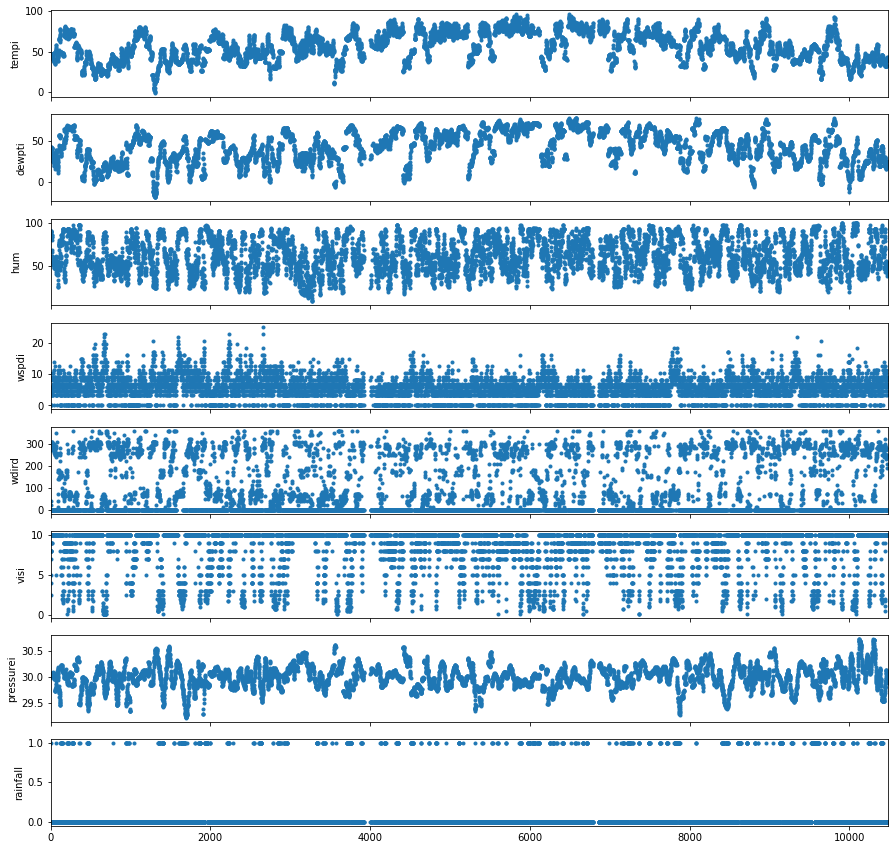

In [14]:
fig, axs = plt.subplots(8, figsize = (15,15),sharex=True)

for i, col in enumerate(cols_pairs):
    df[col].plot(ax = axs[i], style = '.')
    axs[i].set_ylabel(col)

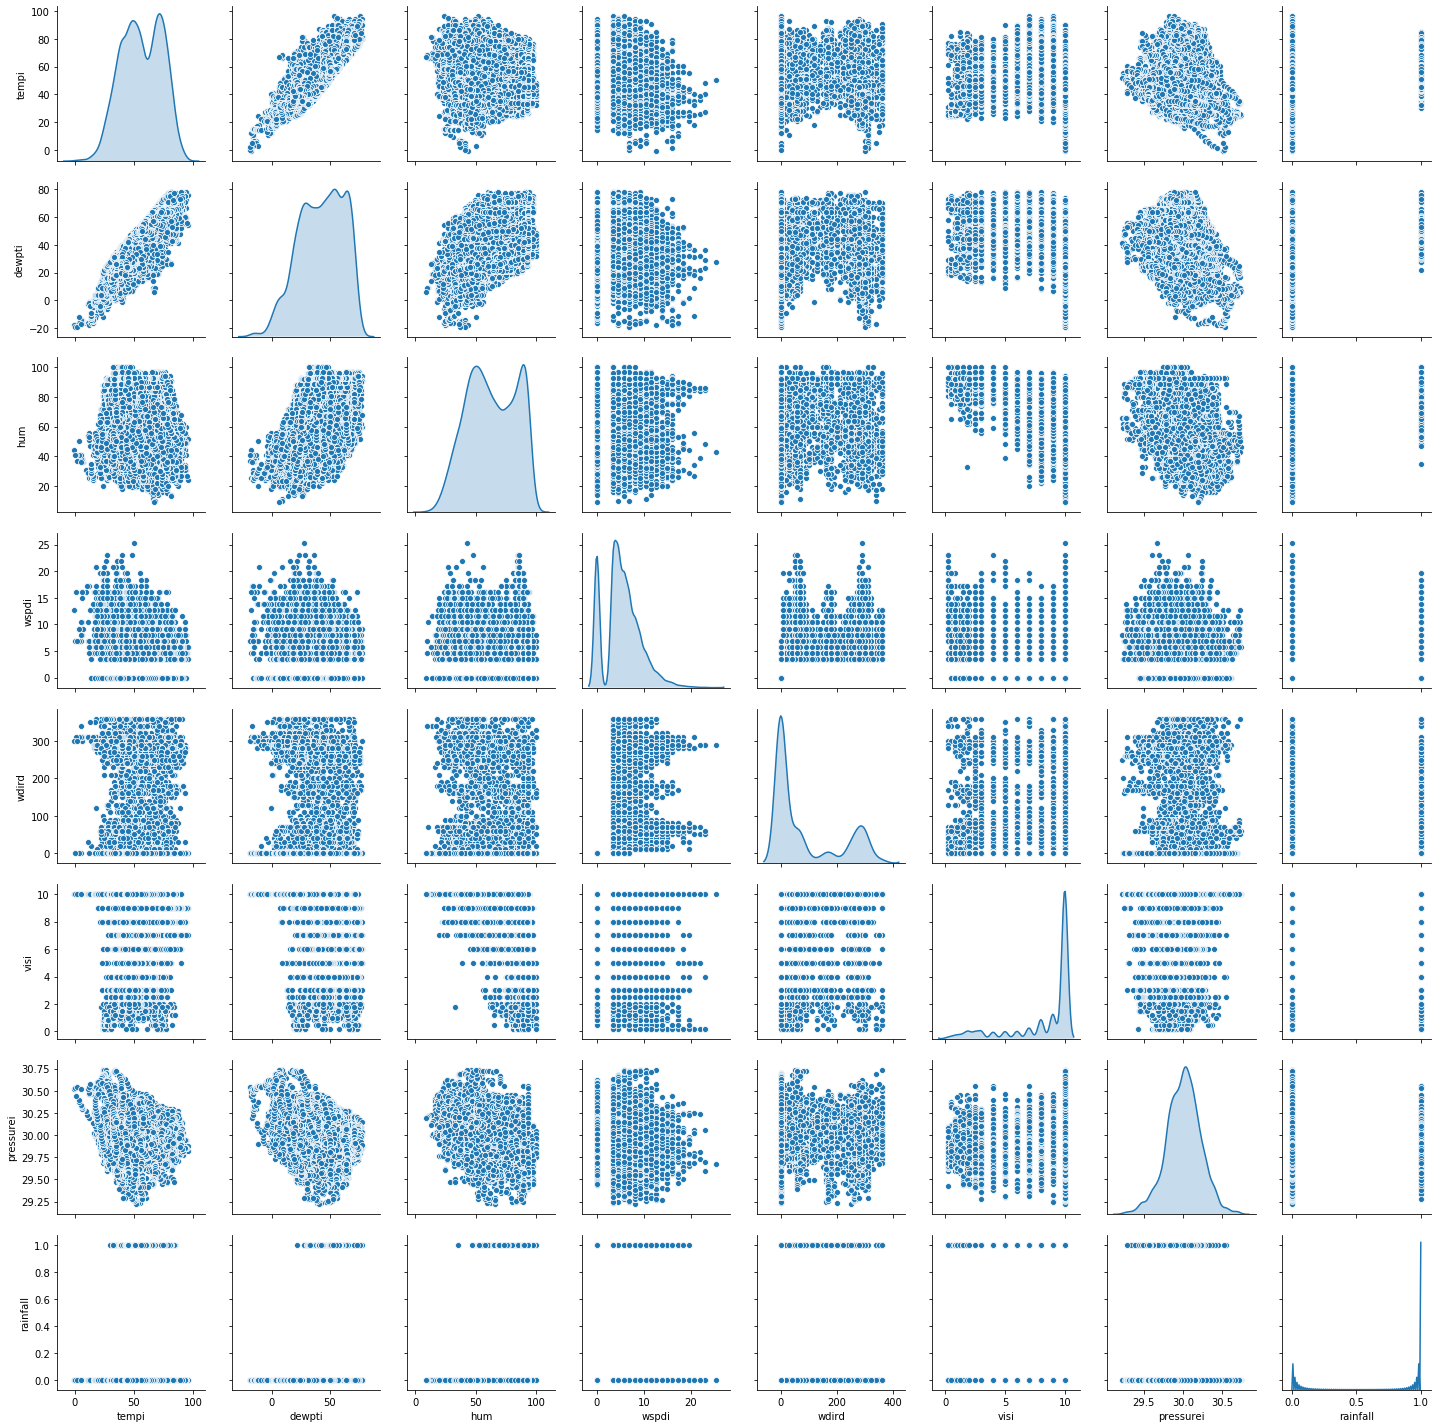

In [15]:
sns.pairplot(df[cols_pairs], diag_kind = 'kde')

### Target: Rain Or Not
0: Sunny
1: Rain

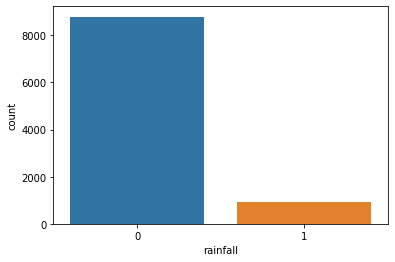

In [16]:
sns.countplot(x='rainfall', data = df)

## Machine Learning DataFrame

In [17]:
df_ml = df

In [18]:
df_ml.head()

,tempi,dewpti,hum,wspdi,wdird,visi,pressurei,DOY,MOD,rainfall
0,46.0,43.0,89.0,4.6,40,2.5,30.07,365,15,1
1,46.0,43.0,89.0,4.6,0,4.0,30.06,365,42,0
2,46.0,43.0,89.0,3.5,20,5.0,30.04,365,51,0
3,45.0,42.1,90.0,4.6,0,8.0,30.02,365,111,0
4,45.0,42.1,90.0,0.0,0,8.0,30.03,365,171,0


In [20]:
y_col = cols[-1]
# print(y_col)
X = df_ml.drop(y_col,axis = 1)
y = df_ml[y_col]

### Normalization

In [21]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, shuffle = True)

In [22]:
# Preprocessing & Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_pre)
# Train and Test data before feature selection
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)

## Classification

Visualization Packages

In [35]:
# visualization packages
from sklearn.metrics import plot_confusion_matrix
def plot_cm(model, X_test,y_test,classes):
    
    np.set_printoptions(precision=2)
    title, normalize = "Normalized confusion matrix", 'true'
    
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    plt.show()    

In [ ]:
classes = np.array(["No Rain", "Rain"])

Classification Models

Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


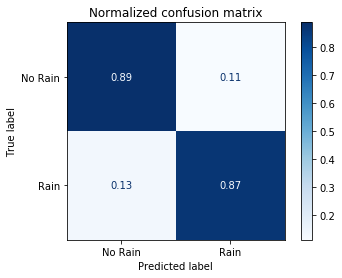

Accuracy on test set: 0.887


In [58]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.98 0.02]
 [0.28 0.72]]


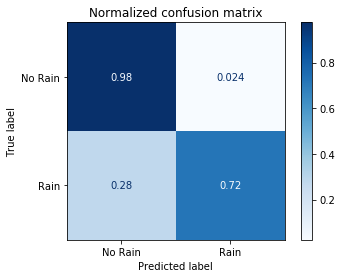

Accuracy on test set: 0.951


In [60]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

k-nearest neighbors

Normalized confusion matrix
[[0.96 0.04]
 [0.38 0.62]]


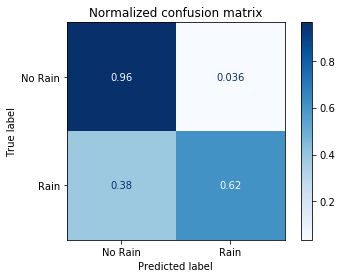

Accuracy on test set: 0.930


In [38]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.98 0.02]
 [0.34 0.66]]


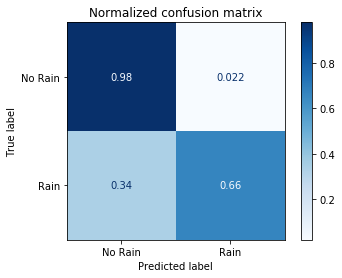

Accuracy on test set: 0.947


In [41]:
# support vector machine (svm)
from sklearn.svm import SVC
model = SVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.97 0.03]
 [0.4  0.6 ]]


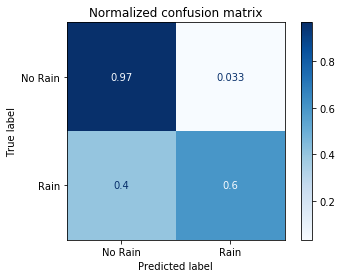

Accuracy on test set: 0.931


In [62]:
from sklearn.svm import LinearSVC
model = LinearSVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.98 0.02]
 [0.29 0.71]]


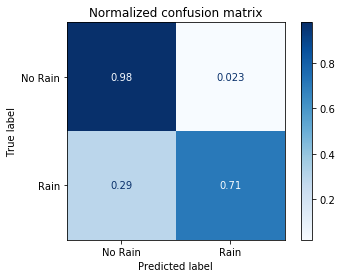

Accuracy on test set: 0.951


In [64]:
from sklearn.gaussian_process import GaussianProcessClassifier
model = GaussianProcessClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.96 0.04]
 [0.29 0.71]]


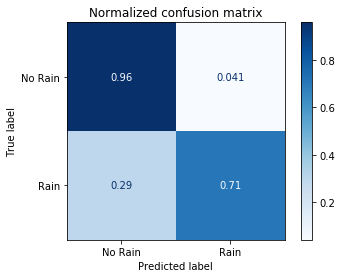

Accuracy on test set: 0.934


In [44]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.96 0.04]
 [0.29 0.71]]


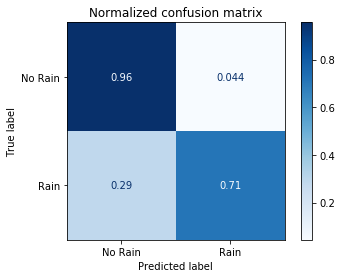

Accuracy on test set: 0.932


In [46]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.97 0.03]
 [0.25 0.75]]


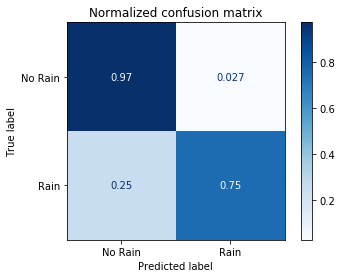

Accuracy on test set: 0.952


In [47]:
# gradient boosted regression trees
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.97 0.03]
 [0.29 0.71]]


C:\Users\yaotang\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


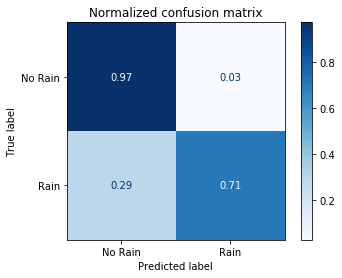

Accuracy on test set: 0.944


In [69]:
# neural networks
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,)).fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

## Imbalanced Learning

In [81]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [83]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

Initial y: Counter({0: 8792, 1: 944})


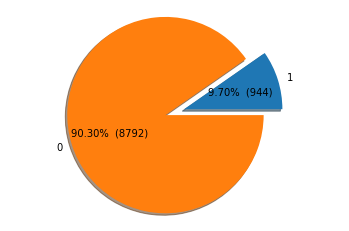

In [113]:
print('Initial y: {}'
      .format( Counter(y)))
plot_pie(y)

### Undersample Majority Class

In [76]:
binary_mask = np.bitwise_or(y == 0, y == 1)

In [77]:
binary_y = y[binary_mask]
binary_X = X[binary_mask]

Information of the iris data set after making it balanced using a float and an under-sampling method: 
 sampling_strategy=0.8 
 y: Counter({0: 1180, 1: 944})


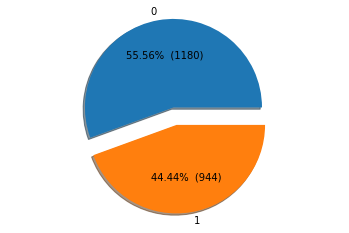

In [84]:
sampling_strategy = 0.8

rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(binary_X, binary_y)
print('Information of the iris data set after making it '
      'balanced using a float and an under-sampling method: \n '
      'sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))
plot_pie(y_res)

### New Model using Resampled Data

In [85]:
# Split train and test data
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X_res, y_res, shuffle = True)

In [86]:
# Preprocessing & Normalization
scaler = StandardScaler()
scaler.fit(X_train_pre)
# Train and Test data before feature selection
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)

Normalized confusion matrix
[[0.88 0.12]
 [0.08 0.92]]


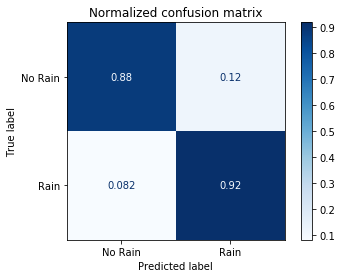

Accuracy on test set: 0.896


In [87]:
# Naive Bayes
model = GaussianNB().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.88 0.12]
 [0.08 0.92]]


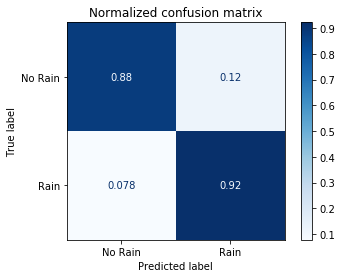

Accuracy on test set: 0.898


In [88]:
model = KNeighborsClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.12 0.88]]


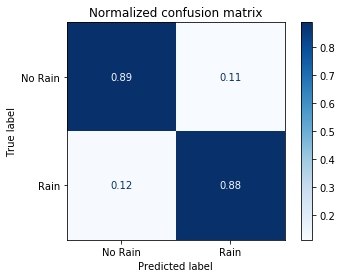

Accuracy on test set: 0.887


In [89]:
model = LogisticRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.08 0.92]]


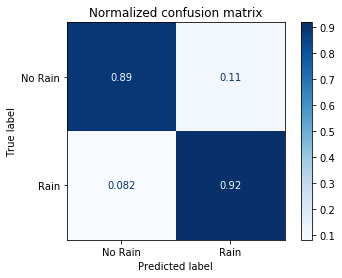

Accuracy on test set: 0.904


In [90]:
model = SVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.12 0.88]]


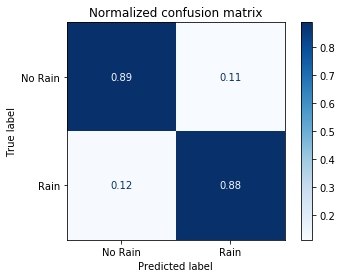

Accuracy on test set: 0.887


In [91]:
# linear SVC
model = LinearSVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.9  0.1 ]
 [0.07 0.93]]


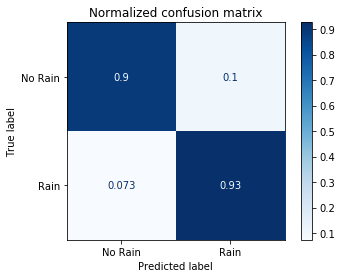

Accuracy on test set: 0.910


In [92]:
# Gaussian Process Classifier
model = GaussianProcessClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


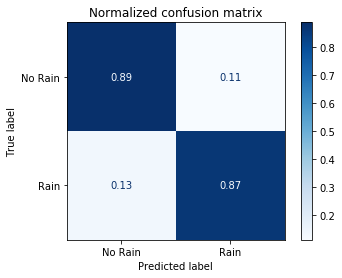

Accuracy on test set: 0.879


In [93]:
# SGD Classifier
model = SGDClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.88 0.12]
 [0.15 0.85]]


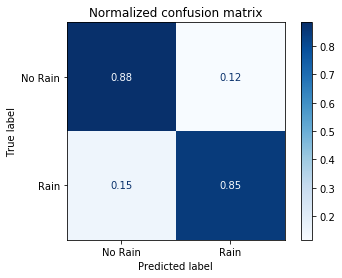

Accuracy on test set: 0.868


In [94]:
# Decision Trees
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.88 0.12]
 [0.15 0.85]]


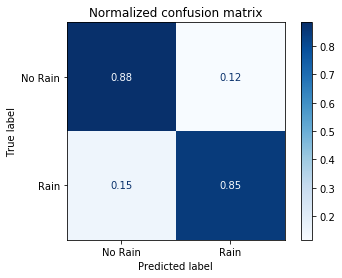

Accuracy on test set: 0.868


In [95]:
# Random Forest
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.91 0.09]
 [0.07 0.93]]


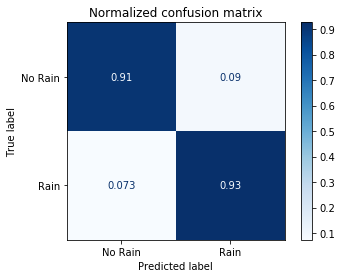

Accuracy on test set: 0.917


In [96]:
# Gradient boosted Regression Trees
model = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.9 0.1]
 [0.1 0.9]]


C:\Users\yaotang\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


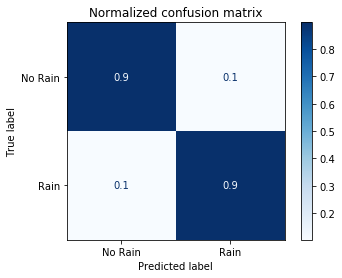

Accuracy on test set: 0.896


In [97]:
# Neural Networks
model = MLPClassifier(hidden_layer_sizes=(100,)).fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

### Oversampling Minority Class

Information of the iris data set after making it balanced using a float and an over-sampling method: 
 sampling_strategy=0.8 
 y: Counter({0: 8792, 1: 7033})


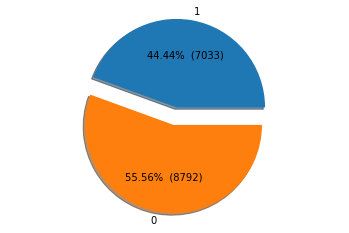

In [98]:
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(binary_X, binary_y)
print('Information of the iris data set after making it '
      'balanced using a float and an over-sampling method: \n '
      'sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))
plot_pie(y_res)

In [99]:
# Split train and test data
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X_res, y_res, shuffle = True)
scaler = StandardScaler()
scaler.fit(X_train_pre)
# Train and Test data before feature selection
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)

Normalized confusion matrix
[[0.87 0.13]
 [0.08 0.92]]


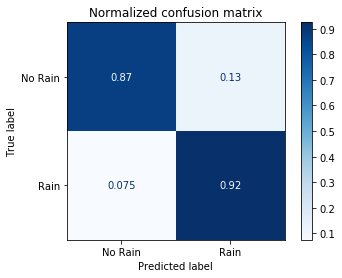

Accuracy on test set: 0.896


In [100]:
model = GaussianNB().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.94 0.06]
 [0.01 0.99]]


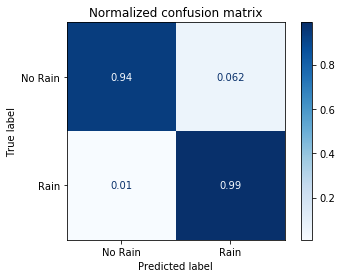

Accuracy on test set: 0.961


In [101]:
model = KNeighborsClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.09 0.91]]


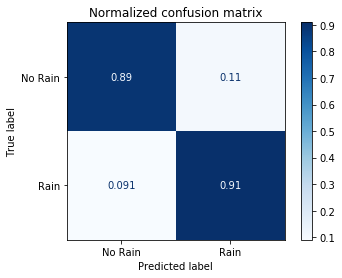

Accuracy on test set: 0.900


In [102]:
model = LogisticRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.92 0.08]
 [0.06 0.94]]


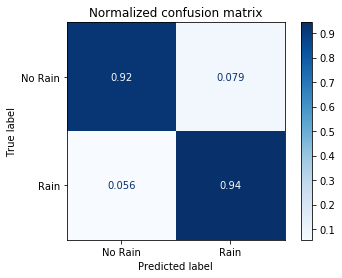

Accuracy on test set: 0.932


In [103]:
model = SVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.89 0.11]
 [0.09 0.91]]


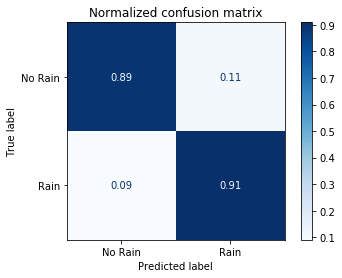

Accuracy on test set: 0.901


In [104]:
model = LinearSVC().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.93 0.07]
 [0.04 0.96]]


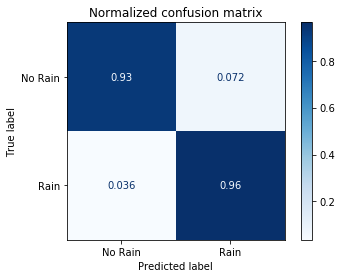

Accuracy on test set: 0.944


In [105]:
model = GaussianProcessClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.9 0.1]
 [0.1 0.9]]


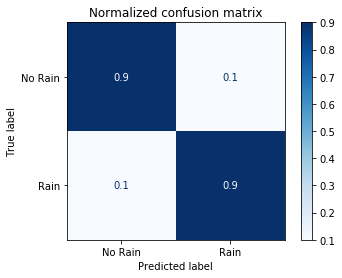

Accuracy on test set: 0.899


In [106]:
model = SGDClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.97 0.03]
 [0.   1.  ]]


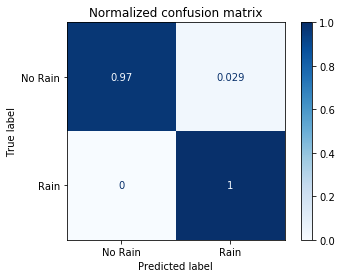

Accuracy on test set: 0.984


In [107]:
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.97 0.03]
 [0.   1.  ]]


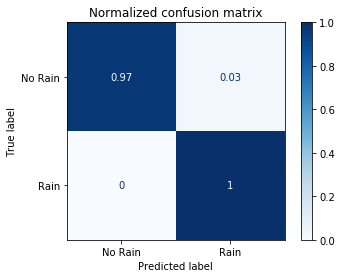

Accuracy on test set: 0.983


In [108]:
model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.93 0.07]
 [0.05 0.95]]


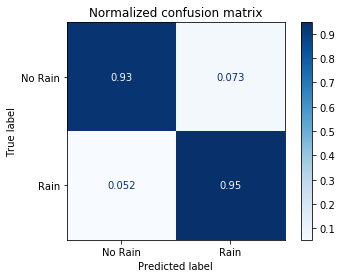

Accuracy on test set: 0.936


In [109]:
model = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Normalized confusion matrix
[[0.94 0.06]
 [0.04 0.96]]


C:\Users\yaotang\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


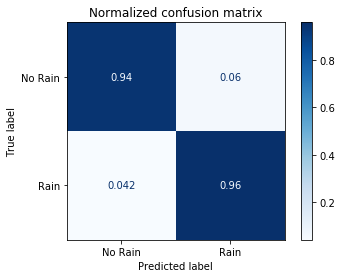

Accuracy on test set: 0.948


In [111]:
model = MLPClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

plot_cm(model, X_test, y_test, classes)
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))